In [7]:
import os, glob, cv2, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm


2025-08-15 21:24:52.308743: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-15 21:24:52.320210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755307492.334237   45772 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755307492.338136   45772 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755307492.347900   45772 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [1]:
ROOT_DIR = "/home/duc/Documents/DoAn/aptos2019-blindness-detection/train"                 # train/0..4
CLASS_DIRS = ["0","1","2","3","4"]
EXT = ".jpg"                       # ảnh đuôi .jpg
METHOD = "ben_graham"              # "ben_graham" | "clahe_lab" | "clahe_green"
TARGET_SIZE = 600                  # ảnh đầu ra (h = w = 600)
APPLY_CIRCULAR_MASK = True         # che góc đen
DO_CROP_FOV = True                 # crop sát vùng võng mạc trước khi resize
MARGIN_CIRCLE = 4                  # rìa trống khi vẽ mask tròn

In [2]:
def list_images(root=ROOT_DIR, class_dirs=CLASS_DIRS, ext=EXT):
    paths = []
    patt = [f"*{ext}", f"*{ext.upper()}"]
    for c in class_dirs:
        d = os.path.join(root, c)
        if not os.path.isdir(d): 
            print(f"[Cảnh báo] không thấy thư mục: {d}")
            continue
        for p in patt:
            paths.extend(glob.glob(os.path.join(d, p)))
    return sorted(paths)

def crop_fov(img, thr=10):
    """Crop sát vùng võng mạc: xác định bbox của các pixel > thr (loại biên đen)."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > thr
    if not np.any(mask):
        return img
    ys, xs = np.where(mask)
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    # phòng hờ biên
    y0 = max(0, y0-2); x0 = max(0, x0-2)
    y1 = min(img.shape[0]-1, y1+2); x1 = min(img.shape[1]-1, x1+2)
    return img[y0:y1+1, x0:x1+1]

def apply_circular_mask(img, margin=MARGIN_CIRCLE):
    """Giữ vùng tròn trung tâm, che góc đen cho ảnh võng mạc."""
    h, w = img.shape[:2]
    r = min(h, w)//2 - margin
    if r <= 0:
        return img
    cx, cy = w//2, h//2
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, (cx, cy), r, 255, -1)
    out = cv2.bitwise_and(img, img, mask=mask)
    return out

def preprocess_ben_graham(bgr, sigma=10):
    """
    Ben Graham preprocessing: giảm non-uniform illumination.
    Công thức phổ biến: out = 4*img - 4*GaussianBlur(img, sigma) + 128
    """
    gb = cv2.GaussianBlur(bgr, (0, 0), sigmaX=sigma, sigmaY=sigma)
    out = cv2.addWeighted(bgr, 4.0, gb, -4.0, 128)
    return np.clip(out, 0, 255).astype(np.uint8)

def preprocess_clahe_lab(bgr, clip=2.0, tile=(8,8)):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def preprocess_clahe_green(bgr, clip=2.0, tile=(8,8)):
    g = bgr[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    g2 = clahe.apply(g)
    # replicate sang 3 kênh để giữ đầu vào 3-channels cho backbone
    return cv2.merge([g2, g2, g2])

def resize_square(img, size=TARGET_SIZE):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def process_one(img_bgr):
    x = img_bgr.copy()
    # 1) Crop vùng FOV (loại viền đen, cắt gọn)
    if DO_CROP_FOV:
        x = crop_fov(x, thr=10)
    # 2) Resize tạm về vuông để mask tròn đẹp
    x = resize_square(x, TARGET_SIZE)
    # 3) Chọn 1 trong các phương pháp tiền xử lý
    if METHOD == "ben_graham":
        x = preprocess_ben_graham(x, sigma=10)
    elif METHOD == "clahe_lab":
        x = preprocess_clahe_lab(x, clip=2.0, tile=(8,8))
    elif METHOD == "clahe_green":
        x = preprocess_clahe_green(x, clip=2.0, tile=(8,8))
    else:
        # không chọn → giữ nguyên
        pass
    # 4) (tuỳ chọn) Circular mask để che góc
    if APPLY_CIRCULAR_MASK:
        x = apply_circular_mask(x, margin=MARGIN_CIRCLE)
    # 5) Đảm bảo kích thước đầu ra
    x = resize_square(x, TARGET_SIZE)
    return x
def process_one_not_clahe(img_bgr):
    x = img_bgr.copy()
    # 1) Crop vùng FOV (loại viền đen, cắt gọn)
    if DO_CROP_FOV:
        x = crop_fov(x, thr=10)
    # 2) Resize tạm về vuông để mask tròn đẹp
    x = resize_square(x, TARGET_SIZE)
    if APPLY_CIRCULAR_MASK:
        x = apply_circular_mask(x, margin=MARGIN_CIRCLE)
    # 5) Đảm bảo kích thước đầu ra
    x = resize_square(x, TARGET_SIZE)
    return x


In [4]:
def write_to_directory(is_clahe):
    paths = list_images()
    print(f"Found {len(paths)} images under {ROOT_DIR}.")
    if not paths:
        return

    ok, fail = 0, 0
    for p in  tqdm( paths,desc="process ben_graham"):
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[skip] cannot read: {p}")
            fail += 1
            continue
        try:
            if is_clahe:
                proc = process_one(img)
            else:
                proc =process_one_not_clahe(img)
            # Ghi đè file gốc (in-place)
            cv2.imwrite(p, proc, [cv2.IMWRITE_JPEG_QUALITY, 95])
            ok += 1
        except Exception as e:
            print(f"[error] {p}: {e}")
            fail += 1

    print(f"Done. Processed={ok}, Failed={fail}, Method={METHOD}, Size={TARGET_SIZE}")

In [5]:
paths = list_images()
print(f"Found {len(paths)} images under {ROOT_DIR}.")

NameError: name 'os' is not defined

In [8]:
write_to_directory(is_clahe=False)

Found 2929 images under /home/duc/Documents/DoAn/aptos2019-blindness-detection/train.


process ben_graham: 100%|██████████| 2929/2929 [02:27<00:00, 19.85it/s]

Done. Processed=2929, Failed=0, Method=ben_graham, Size=600


In [8]:
def show_one_and_clone(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)

    proc = process_one(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    print(proc[350][350])
    ax1.imshow(img)
    ax1.set_title('goc')

    ax2.imshow(proc)
    ax2.set_title('ben_graham')

    plt.show()

In [6]:
def show_one_and_clone_not_clahe(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)

    proc = process_one_not_clahe(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    print(proc[350][350])
    ax1.imshow(img)
    ax1.set_title('goc')

    ax2.imshow(proc)
    ax2.set_title('ben_graham')

    plt.show()

[26 26 26]


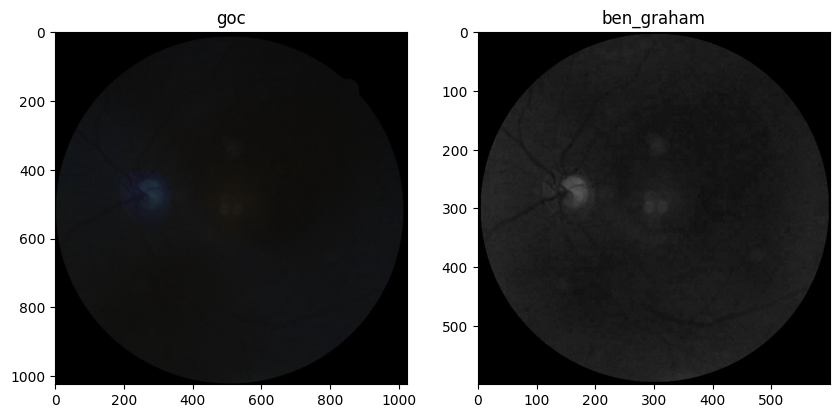

In [45]:

show_one_and_clone("eyepacs_2015/train/2/42832_left.jpg")

[101 150 226]


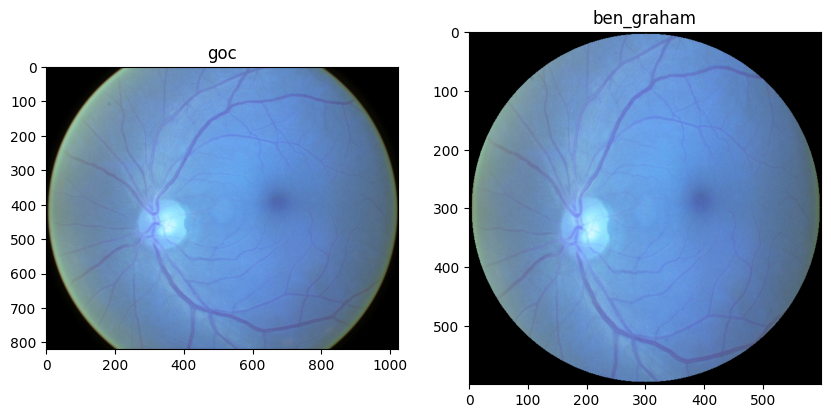

In [14]:

show_one_and_clone_not_clahe("eyepacs_2015/train_origin/81_right.jpeg")